# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Imports

In [1]:
import tarfile
import os
import scipy.io
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray
import skimage.morphology as mp

In [2]:
data_base_path = ('data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [3]:
def load_images():

    train_dir = os.path.join(data_base_path, data_folder +'/images/train/')
    dir_train_list = sorted(os.listdir(train_dir))
    train = [skimage.io.imread(os.path.join(train_dir, file)) for file in dir_train_list]

    
    test_dir = os.path.join(data_base_path, data_folder +'/images/test/')
    dir_test_list = sorted(os.listdir(test_dir))
    test = [skimage.io.imread(os.path.join(test_dir, file)) for file in dir_test_list]
    
    val_dir = os.path.join(data_base_path, data_folder +'/images/validation/')
    dir_val_list = sorted(os.listdir(val_dir))
    validation = [skimage.io.imread(os.path.join(val_dir, file)) for file in dir_val_list]
    
    return train, test, validation

In [4]:
def parse_xml_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [5]:
train, test, validation = load_images()

In [6]:
def load_annotations():
    dir_train = os.path.join(data_base_path, data_folder + '/annotations/train/')
    dir_train_list = sorted(os.listdir(dir_train))
    train_files = [f for f in dir_train_list if os.path.isfile(os.path.join(dir_train, f))]
    train_annotations = [parse_xml_file(os.path.join(dir_train, file)) for file in train_files]
    
    
    dir_test = os.path.join(data_base_path, data_folder + '/annotations/test/')
    dir_test_list = sorted(os.listdir(dir_test))
    test_files = [f for f in dir_test_list if os.path.isfile(os.path.join(dir_test, f))]
    test_annotations = [parse_xml_file(os.path.join(dir_test, file)) for file in test_files]
    
    dir_val = os.path.join(data_base_path, data_folder + '/annotations/validation/')
    dir_val_list = sorted(os.listdir(dir_val))
    val_files = [f for f in dir_val_list if os.path.isfile(os.path.join(dir_val, f))]
    validation_annotations = [parse_xml_file(os.path.join(dir_val, file)) for file in val_files]
    
    return train_annotations, test_annotations, validation_annotations

In [7]:
train_annotations, test_annotations, validation_annotations = load_annotations()

# Preprocessing 


In [8]:
def remove_yellow(img):
    out = img.copy()
    
    red = out[:,:,0]
    green = out[:,:,1]
    blue = out[:,:,2]
    
    is_yellow =  (red > 100) & (red < 250) & (green > 100) & (green < 250) & (blue > 0) & (blue < 200)
    
    red[is_yellow] = 255
    green[is_yellow] = 255
    blue[is_yellow] = 255
    
    out[:,:,0] = red
    out[:,:,1] = green
    out[:,:,2] = blue
    
    return out

In [9]:
#Thresholding the image between two thresholds
def threshold(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 255
    return th_img

In [10]:
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))
    return img_th
    

In [11]:
def preprocess_images(train, test, validation):
    for i in range(len(train)):
        train[i] = preprocess_image(train[i])
        
    for i in range(len(test)):
        test[i] = preprocess_image(test[i])
        
    for i in range(len(validation)):
        validation[i] = preprocess_image(validation[i])
         
    return train, test, validation


In [12]:
train_pro, test_pro, validation_pro = preprocess_images(train, test, validation[0:2])

/anaconda3/envs/ada/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [13]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [14]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [15]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

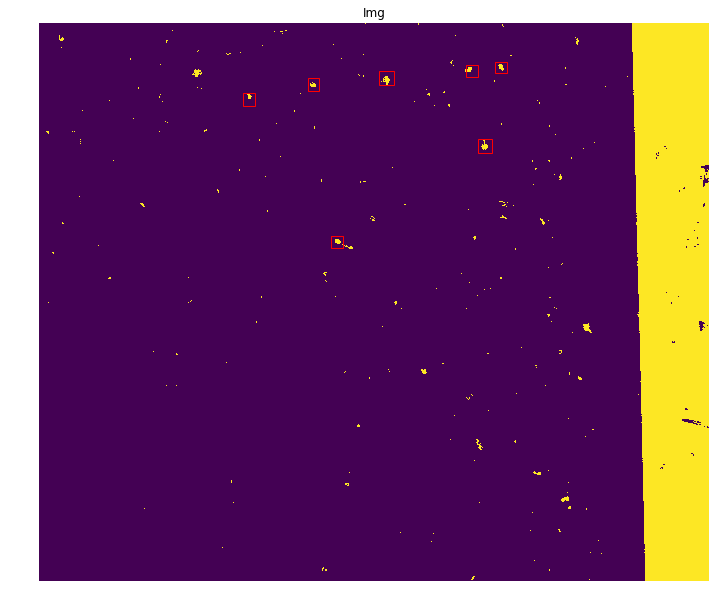

In [16]:
# Plot images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# Iterate over annotations
for anno in train_annotations[3]:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(train[3])
ax.axis('off')
ax.set_title('Img')
plt.show()

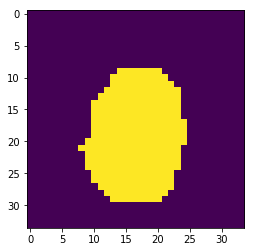

In [17]:
#Your code
bbox = train_annotations[0][0]['bbox']
plt.imshow(train[0][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]])
#cv2.drawContours(image=ic, contours=contours, contourIdx=-1, color=(0,255,0), thickness=1)

#plt.imshow(ic, cmap='gray')

In [18]:
def get_window_size(annotations):
    width = []
    height = []
    for i in range(len(annotations)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            width.append(bbox[2])
            height.append(bbox[3])
            
    avg_width = int(np.round(np.mean(width)))
    avg_height = int(np.round(np.mean(height)))
    return avg_width, avg_height

In [19]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [20]:
def get_contours_fake(images, annotations):
    max_len = 0
    all_contours = []
    w_width, w_height = get_window_size(annotations)
    
    for i in range(len(images)):
        for window in sliding_window(images[i], int((w_width/3)*2), (w_width, w_height)):
            im_bw = window[2]

            # Find contours using opencv
            _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Reshape to easily get x and y
            if (len(contours) == 0):
                contours_np = np.array([[0, 0]])
                all_contours.append(contours_np)
            else:
                contours_np = contours[0][:, 0, :]
                all_contours.append(contours_np)
        
            if (max_len < contours_np.shape[0]):
                max_len = contours_np.shape[0]

    return max_len, np.array(all_contours)             

In [21]:
empty_anno_index = []
for i in range(len(train_annotations)):
    if len(train_annotations[i]) == 0:
        empty_anno_index.append(i)
empty_anno_index = empty_anno_index[:10]
empty_anno_index
empty_pics = [train_pro[i] for i in empty_anno_index]

In [22]:
def get_contours(images, annotations):
    max_len = 0
    all_contours = []
    
    for i in range(len(images)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            img_box = images[i][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]].copy()
            im_bw = img_box

            # Find contours using opencv
            _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Reshape to easily get x and y
            if (len(contours) != 0):
                contours_np = contours[0][:, 0, :]
                all_contours.append(contours_np)

                if (max_len < contours_np.shape[0]):
                    max_len = contours_np.shape[0]

    return max_len, np.array(all_contours)

In [23]:
def fourier_descriptor(contours_np, length):
    
    # Pad contour to max contour length
    for i in range(length - len(contours_np)):
        contours_np = np.concatenate([contours_np, np.array([[0, 0]])])
    
    # Create imag nums and descriptors
    u_k = contours_np[:, 0] + 1j*contours_np[:, 1]
    
    fr = np.fft.fft(u_k)
    
    # Only return the 2nd and 3rd
    return [fr[1], fr[2], fr[3]]

In [24]:
max_len_fake, contours_fake = get_contours_fake(empty_pics, train_annotations)
max_len, contours = get_contours(train_pro, train_annotations)

features_real = np.abs([(fourier_descriptor(c, max(max_len, max_len_fake))) for c in contours])
features_fake = np.abs([(fourier_descriptor(c, max(max_len, max_len_fake))) for c in contours_fake])

In [25]:
features_real = np.c_[ features_real, np.zeros(features_real.shape[0]) ]  
features_fake = np.c_[ features_fake, np.ones(features_fake.shape[0])]
train_features = np.vstack((features_real, features_fake))

In [26]:
def plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(X_zeros, Y_zeros, marker='o', color='red', label='Real')
    ax.scatter(X_ones, Y_ones, marker='^', color='blue', label='Fake')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    plt.show()

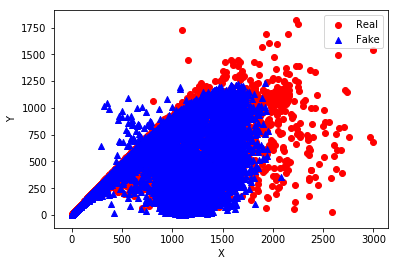

In [27]:
plot_descriptors(features_real[:, 0], features_real[:, 1], features_fake[:, 0], features_fake[:, 1])

In [28]:
def plot_descriptors_3D(class0, class1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(class0[:,0], class0[:,1], class0[:,2], marker='o', color='red', label='Real')
    ax.scatter(class1[:,0], class1[:,1], class1[:,2], marker='^', color='blue', label='Fake')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

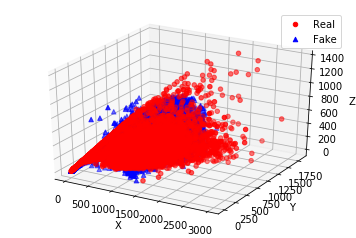

In [29]:
plot_descriptors_3D(features_real, features_fake)

In [30]:
clf = GaussianNB()
clf.fit(train_features[:, 0:3], train_features[:, 3])

GaussianNB(priors=None, var_smoothing=1e-09)

In [31]:
clf.score(train_features[:, 0:3], train_features[:, 3])

0.9080770908602812

In [32]:
from sklearn import svm
clf_svm = svm.SVC(probability=True)
clf_svm.fit(train_features[:, 0:3], train_features[:, 3])

/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
clf_svm.score(train_features[:, 0:3], train_features[:, 3])

0.9921029966107762

# Test the detection

In [34]:
def detect_by_method_1_ver1(image):
    window_shape = (30, 30)
    padding = max(max_len, max_len_fake)
    varroas = []
    for window in sliding_window(image, int((window_shape[0]/3)*2), window_shape):
        im_bw = window[2]

        # Find contours using opencv
        _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print(len(contours))

        # Reshape to easily get x and y
        if (len(contours) > 0):
            contours_np = contours[0][:, 0, :]
            descriptor = np.abs(fourier_descriptor(contours_np, padding))
            prob = clf_svm.predict_proba(np.array([[descriptor[0], descriptor[1], descriptor[2]]]))[0][0]
            # print(prob)
            if (prob > 0.90):
                varroas.append([window[0], window[1], window_shape[0], window_shape[1]])

    return varroas

In [35]:
def precision(tp, fp):
    return tp / (tp + fp)

In [36]:
def recall(tp, fn):
    return tp / (tp + fn)

In [37]:
def f1_score(tp, fp, fn):
    if (tp == 0):
        return 0
    return 2 * precision(tp, fp) * recall(tp, fn) / (precision(tp, fp) + recall(tp, fn))

In [38]:
def iou_bbox(predict, true):
    """
    Calculate the IoU for two bounding boxes.
    Based on:
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    """
    
    # Determine the coordinates of the intersection rectangle
    x_left = max(predict[1], true[0])
    y_top = max(predict[0], true[1])
    x_right = min(predict[3], true[0] + true[2])
    y_bottom = min(predict[2], true[1] + true[3])
    
    # If they do not overlap, return 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute area for both bounding boxes
    bb1_area = (predict[3] - predict[1]) * (predict[2] - predict[0])
    bb2_area = true[2] * true[3]

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

In [39]:
tp = 0
fp = 0
fn = 0

for i in range(len(test_pro[0:10])):
    # predict veronas
    varroas_pred = detect_by_method_1_ver1(test_pro[i])
    
    # get true bounding boxes
    varroas_true = []
    for bbox in test_annotations[i]:
           varroas_true.append(bbox['bbox'])
    
    # get true and false positives
    positives = []
    
    for pb in varroas_pred:
        true_pos = False
        
        for tb in varroas_true:
            if(iou_bbox(pb, tb) > 0.3):
                true_pos = True
        positives.append(true_pos)
    
    tp += positives.count(True)
    fp += positives.count(False)
    
    # get the false negatives
    negatives = []
    
    for tb in varroas_true:
        fn = False
        
        for pb in varroas_pred:
            if(iou_bbox(pb, tb) > 0.3):
                fn = True
        negatives.append(fn)
    
    # Count all times no intersection was found
    fn += negatives.count(False)
    
# Calculate precision and recall
precision = precision(tp, fp)
recall = recall(tp, fn)
    
print('The values for the given test images')
print('Precision %f' % precision)
print('Recall %f' % recall)
print('F1-Score %f\n' % f1_score(tp, fp, fn))

The values for the given test images
Precision 0.000000
Recall 0.000000
F1-Score 0.000000



# Future problem

In [46]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [49]:
windows = sliding_window(train[2], 100, (300, 300))

In [52]:
import argparse
import time
import cv2
(winW, winH) = (300, 300)

In [54]:
for (x, y, window) in sliding_window(train[2], 100, (winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
    # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
    # WINDOW



KeyboardInterrupt: 

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code